In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report

In [4]:
!ls

anomaly_detection.ipynb
baseline.ipynb
submission.csv
test.csv
train.csv
venv
Пояснение к датасету.docx


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
sample_submission = pd.read_csv('submission.csv')

In [8]:
TYPE_DICT = {'Запрос': 0, 'Инцидент': 1}

In [9]:
def preprocess(df, is_train=True):
    df = df.copy()
    
    df['Дата закрытия обращения'] = pd.to_datetime(df['Дата закрытия обращения'])
    df['Дата обращения'] = pd.to_datetime(df['Дата обращения'])

    df['open_date'] = df['Дата обращения'].dt.date
    df['close_date'] = df['Дата закрытия обращения'].dt.date
    
    if is_train:
        df['Тип обращения итоговый'] = df['Тип обращения итоговый'].map(TYPE_DICT)
    
    return df

In [10]:
train = preprocess(train)
test = preprocess(test, False)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train, train['Тип обращения итоговый'])

# Начнем с базовой модельки без учета времени

In [12]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg = LogisticRegression(C=10**4, max_iter=500)

In [ ]:
tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
logreg.fit(tf_idf.transform(X_train['Содержание'].fillna('NO DATA')), y_train)

print(classification_report(y_test, 
                            (logreg.predict_proba(tf_idf.transform(
                                X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1] > 0.35).astype(int)))

In [15]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg = LogisticRegression(C=10**3, max_iter=500)

In [ ]:
tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
logreg.fit(tf_idf.transform(X_train['Содержание'].fillna('NO DATA')), X_train['Тип переклассификации'])

print(classification_report(X_test['Тип переклассификации'], 
                            logreg.predict(tf_idf.transform(X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))))

# Учтем время

In [ ]:
train['Дата обращения'].min(), train['Дата обращения'].max()

In [18]:
X_train, X_test = (train[train['Дата обращения'] < pd.to_datetime('2018-02-01 00:00:00')], 
                  train[train['Дата обращения'] >= pd.to_datetime('2018-02-01 00:00:00')])

In [19]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg = LogisticRegression(C=10**4, max_iter=500)

In [ ]:
tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
logreg.fit(tf_idf.transform(X_train['Содержание'].fillna('NO DATA')), X_train['Тип обращения итоговый'])

print(classification_report(X_test['Тип обращения итоговый'], 
                            (logreg.predict_proba(tf_idf.transform(
                                X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1] > 0.35).astype(int)))

In [ ]:
X_test['prob'] = logreg.predict_proba(tf_idf.transform(
                                X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1]

In [ ]:
X_test['start_date_round'] = X_test['Дата обращения'].dt.round("3H")

# Посмотрим на ряд вероятностей инцидентов во времени

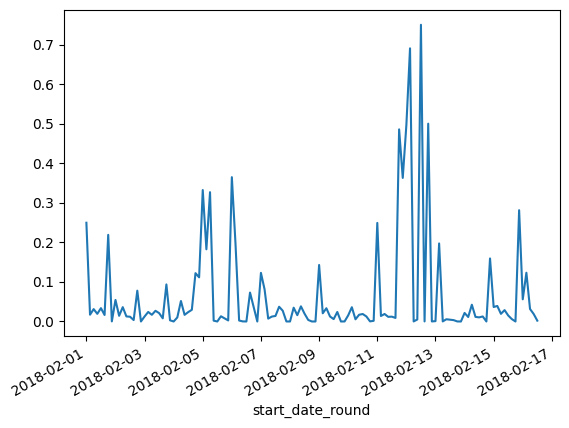

In [26]:
X_test.groupby(by='start_date_round')['prob'].mean().plot();

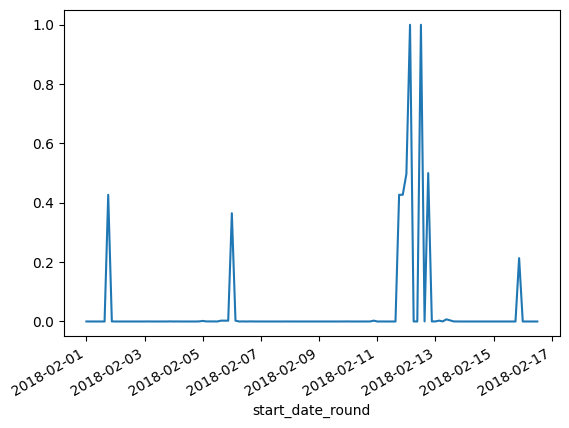

In [27]:
X_test.groupby(by='start_date_round')['prob'].median().plot();

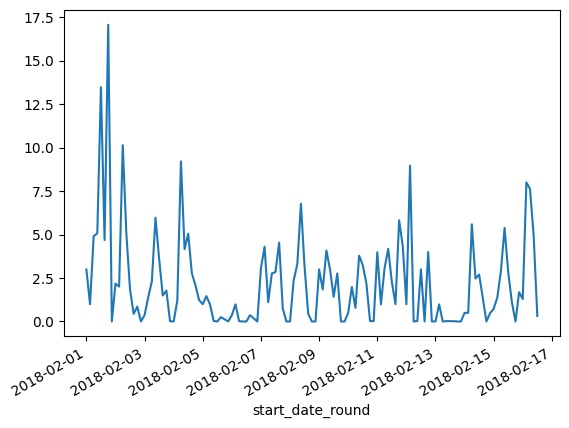

In [29]:
X_test.groupby(by='start_date_round')['prob'].sum().plot();

# Попробуем сделать кластеризацию, чтобы выделить основные кластеры

In [178]:
tf_idf = TfidfVectorizer(analyzer='word', max_features=5000)

In [ ]:
cluster_inerias = []
train_data = tf_idf.fit_transform(train['Содержание'].fillna('NO DATA').str.replace('\*', ''))

for n in range(2, 30):
    mb_kmeans = MiniBatchKMeans(n_clusters=n)
    mb_kmeans.fit(train_data)
    cluster_inerias.append(mb_kmeans.inertia_)

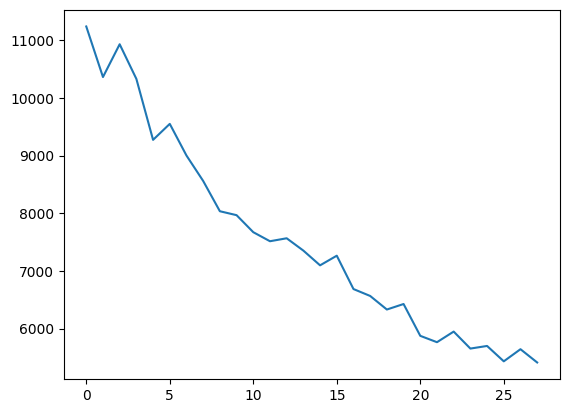

In [186]:
plt.plot(cluster_inerias);

In [181]:
mb_kmeans = MiniBatchKMeans(n_clusters=10)

train['cluster'] = mb_kmeans.fit_predict(train_data)

In [187]:
train['cluster'].value_counts()

cluster
3    5940
1    3140
2    1217
5    1080
6    1025
0     612
8     580
4     571
9     391
7     247
Name: count, dtype: int64

In [188]:
train.groupby(['cluster'])['Тип обращения итоговый'].mean()

cluster
0    0.000000
1    0.000000
2    0.000000
3    0.046801
4    0.000000
5    0.000926
6    0.000976
7    0.000000
8    0.000000
9    0.319693
Name: Тип обращения итоговый, dtype: float64

Cluster 0:


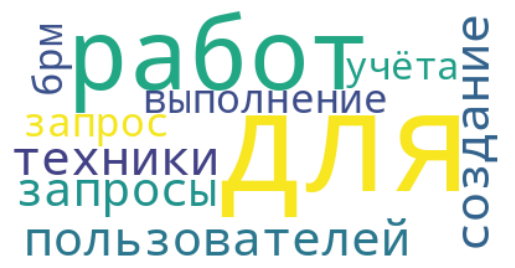

Cluster 1:


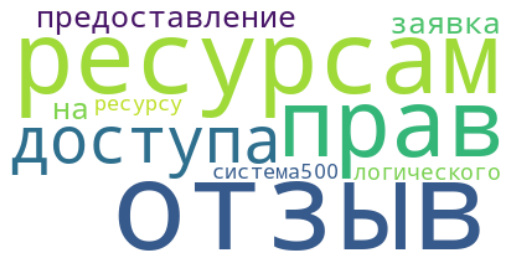

Cluster 2:


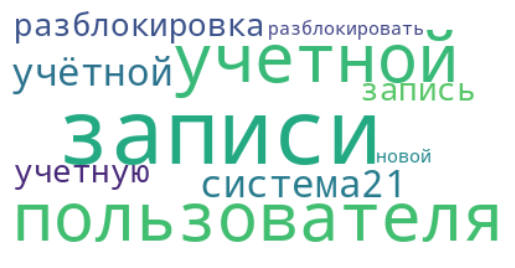

Cluster 3:


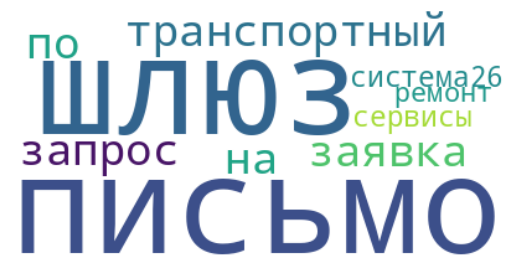

Cluster 4:


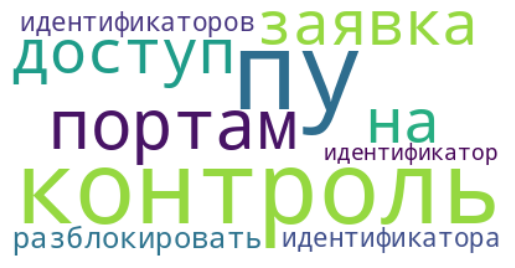

Cluster 5:


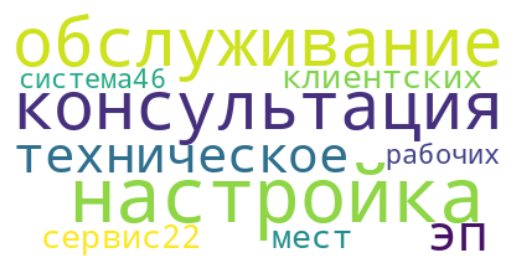

Cluster 6:


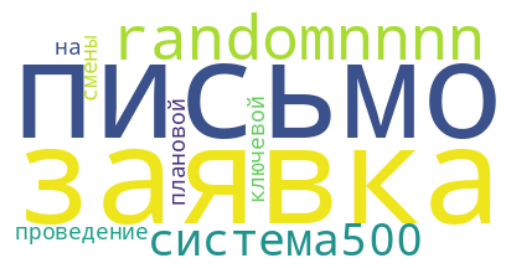

Cluster 7:


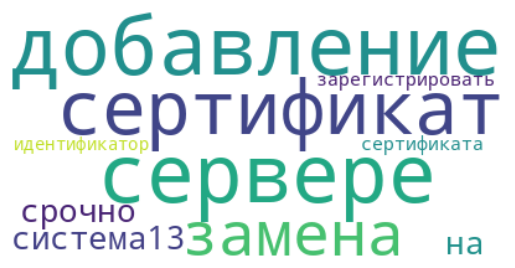

Cluster 8:


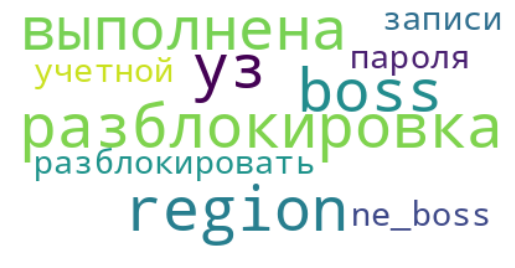

Cluster 9:


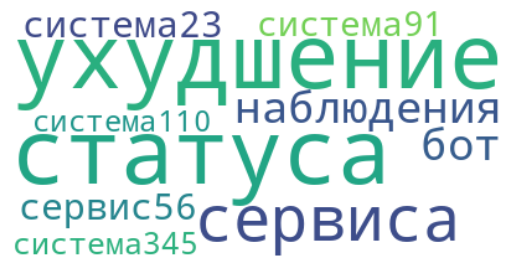

In [189]:
from wordcloud import WordCloud
order_centroids = mb_kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf.get_feature_names_out()

for i in range(10):
    print(f"Cluster {i}:")
    words = [terms[ind] for ind in order_centroids[i, :10]]
    wc = WordCloud(background_color="white", max_words=10).generate(" ".join(words))

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [191]:
# Посмотрим на 9 кластер, где в основном сгруппировались инциденты
train[train['cluster'] == 9][:10]

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,...,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,cluster,prob,start_date_round
59,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-31 07:51,2018-01-26 03:43:00,Запрос,0,Поток *********** отработал штатно.,...,2018-02-02 07:52:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-02,9,0.063846,2018-01-26 03:00:00
152,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-31 07:52,2018-01-26 06:42:00,Запрос,0,Поток ********* завершен успешно,...,2018-02-02 09:44:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-02,9,0.063846,2018-01-26 06:00:00
353,<Бот-наблюдения> Система11. Ухудшение статуса ...,Сервис11,3-Низкий,Закрыт,ФГ62,2018-01-31 09:36,2018-01-26 08:21:00,Запрос,0,"временная нагрузка. очереди сообщений нет, соб...",...,2018-02-02 10:13:00,4-Нет,3-Малое,Система11,Место1,2018-01-26,2018-02-02,9,0.186666,2018-01-26 09:00:00
378,<Бот-наблюдения> Сервис56. Ухудшение статуса с...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-31 09:55,2018-01-26 08:45:00,Запрос,0,Abort выполнялся в рамках **********,...,2018-02-02 10:38:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-02,9,0.054344,2018-01-26 09:00:00
404,<Бот-наблюдения> Система368. Ухудшение статуса...,Сервис320,3-Низкий,Закрыт,ФГ56,2018-01-31 10:08,2018-01-26 08:58:00,Запрос,0,Самовосстановление,...,2018-02-02 10:38:00,2-Повышенная,3-Малое,Система368,Место1,2018-01-26,2018-02-02,9,0.923729,2018-01-26 09:00:00
469,<Бот-наблюдения> Сервис56. Ухудшение статуса с...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-31 10:55,2018-01-26 09:45:00,Запрос,0,Abort выполнялся в рамках **********,...,2018-02-02 11:49:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-02,9,0.054344,2018-01-26 09:00:00
758,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ19,2018-01-27 13:48,2018-01-26 14:48:00,Запрос,0,Поток ********* завершен успешно,...,2018-02-03 07:23:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-03,9,0.063846,2018-01-26 15:00:00
849,<Бот-наблюдения> Система11. Ухудшение статуса ...,Сервис11,3-Низкий,Закрыт,ФГ62,2018-02-01 07:51,2018-01-26 15:51:00,Запрос,0,Выполнена проверка почтовых очередей Система11...,...,2018-02-03 07:52:00,4-Нет,3-Малое,Система11,Место1,2018-01-26,2018-02-03,9,0.186666,2018-01-26 15:00:00
878,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ201,2018-01-27 10:36,2018-01-26 17:18:00,Запрос,0,Замедления загрузок данных средствами Система5...,...,2018-02-03 12:43:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-03,9,0.063846,2018-01-26 18:00:00
879,<Бот-наблюдения> Система23. Ухудшение статуса ...,Сервис23,2-Средний,Закрыт,ФГ201,2018-01-27 10:36,2018-01-26 17:24:00,Запрос,0,Замедления загрузок данных средствами Система5...,...,2018-02-03 12:49:00,1-Особая,3-Малое,Система23,Место1,2018-01-26,2018-02-03,9,0.063846,2018-01-26 18:00:00


## Видим, что у нас реально есть кластера, на которые важнее обращать внимание при оценке инцидентов

# Итоговое обучение модели


In [ ]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg_obrasheniya = LogisticRegression(C=10**4, max_iter=500)
logreg_pereclassification = LogisticRegression(C=10**4, max_iter=500)

tf_idf.fit(train['Содержание'].fillna('NO DATA').str.replace('\*', ''))

logreg_obrasheniya.fit(tf_idf.transform(train['Содержание'].fillna('NO DATA')), train['Тип обращения итоговый'])
logreg_pereclassification.fit(tf_idf.transform(train['Содержание'].fillna('NO DATA')), train['Тип переклассификации'])


preds_pereclassification = logreg_pereclassification.predict(tf_idf.transform(test['Содержание'].fillna('NO DATA').str.replace('\*', '')))

preds_obrasheniya = (logreg_obrasheniya.predict_proba(tf_idf.transform(
                                test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1] > 0.35).astype(int)

sample_submission["Тип переклассификации"] = preds_pereclassification
sample_submission["Тип обращения итоговый"] = preds_obrasheniya
sample_submission["Тип обращения итоговый"] = sample_submission["Тип обращения итоговый"].map(dict((v, k) for k, v in TYPE_DICT.items()))

In [83]:
# распределение на трейне
train["Тип обращения итоговый"].value_counts(normalize=True)

Тип обращения итоговый
0    0.972641
1    0.027359
Name: proportion, dtype: float64

In [85]:
# распределение на тесте
sample_submission["Тип обращения итоговый"].value_counts(normalize=True)

Тип обращения итоговый
Запрос      0.980927
Инцидент    0.019073
Name: proportion, dtype: float64

In [87]:
# # распределение на трейне
train["Тип переклассификации"].value_counts(normalize=True)

Тип переклассификации
0    0.975816
2    0.014727
1    0.009458
Name: proportion, dtype: float64

In [86]:
# # распределение на тесте
sample_submission["Тип переклассификации"].value_counts(normalize=True)

Тип переклассификации
0    0.980927
2    0.013871
1    0.005202
Name: proportion, dtype: float64

In [88]:
sample_submission.to_csv("final_submission.csv", index=None)

# Подсчет аномалий

In [89]:
train["prob"] = logreg_obrasheniya.predict_proba(tf_idf.transform(train['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1]
test["prob"] = logreg_obrasheniya.predict_proba(tf_idf.transform(test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1]
train['start_date_round'] = train['Дата обращения'].dt.round("3H")
test["start_date_round"] = test['Дата обращения'].dt.round("3H")

In [125]:
median_absolute_deviation = lambda y: np.median(np.abs(y - np.median(y)))
def calculate_anomalies(ts, metric, factor, title="Аномалии", ylabel="Количество обращений"):
    
    df_ = ts.copy()
    df_rolling_stats = (
        df_[metric]
        .rolling(
            window=49,
            center=True,
            min_periods=2,
        )
        .agg({"rolling_mean": "mean", "rolling_std": "std"})
    )
    df_[["rolling_mean", "rolling_std"]] = df_rolling_stats

    df_["is_anomaly"] = np.abs(df_[metric] - df_["rolling_mean"]) > factor * df_["rolling_std"]
    df_["upper"] = df_["rolling_mean"] + factor * df_["rolling_std"]
    df_["lower"] = df_["rolling_mean"] - factor * df_["rolling_std"]
    _, ax = plt.subplots(figsize=[10, 5])
    df_.plot(y=[metric, "rolling_mean"], marker=".", ax=ax)
    df_.plot(
        y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
    )
    if df_["is_anomaly"].any():
        df_[metric].loc[df_["is_anomaly"]].plot(
            marker="o", color="r", ax=ax, legend=None, linestyle=""
        )
        
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time")

    return df_[df_["is_anomaly"] == True].index


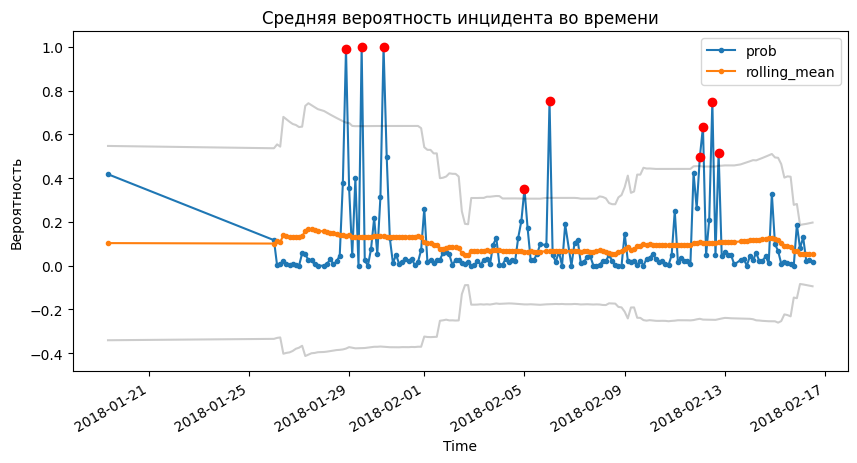

In [134]:
ts_train = train.groupby(by='start_date_round')['prob'].mean().to_frame()
anomaly_dates_probs_train = calculate_anomalies(ts_train, 
                    "prob", 
                    factor=2,
                    title="Средняя вероятность инцидента во времени",
                    ylabel="Вероятность");
# 9 инцидентов на трейне

# Можно посмотреть на конкретные даты

In [185]:
anomaly_dates_probs_train

DatetimeIndex(['2018-01-28 21:00:00', '2018-01-29 12:00:00',
               '2018-01-30 09:00:00', '2018-02-05 00:00:00',
               '2018-02-06 00:00:00', '2018-02-12 00:00:00',
               '2018-02-12 03:00:00', '2018-02-12 12:00:00',
               '2018-02-12 18:00:00'],
              dtype='datetime64[ns]', name='start_date_round', freq=None)

In [142]:
train[train["start_date_round"] == "2018-02-12 12:00:00"]

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,...,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,cluster,prob,start_date_round
12447,Система26,Сервис26,2-Средний,Закрыт,ФГ154,2018-02-17 06:36,2018-02-12 11:04:00,Запрос,0,"Добрый день. РК удалена, проект возвращён испо...",...,2018-02-21 07:51:00,1-Особая,3-Малое,Система26,Место97,2018-02-12,2018-02-21,0,7.804929e-14,2018-02-12 12:00:00
12448,<Бот-наблюдения> Система57 Система91. Ухудшени...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-12 20:44,2018-02-12 12:44:00,Инцидент,1,Выполняется штатная перезагрузка серверов сотр...,...,2018-02-21 07:51:00,1-Особая,3-Малое,Система91,Место1,2018-02-12,2018-02-21,7,1.000000e+00,2018-02-12 12:00:00
12449,<Бот-наблюдения> Система91. Ухудшение статуса ...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-12 20:46,2018-02-12 12:46:00,Инцидент,1,Выполняется штатная перезагрузка серверов сотр...,...,2018-02-21 07:51:00,1-Особая,3-Малое,Система91,Место1,2018-02-12,2018-02-21,7,9.999998e-01,2018-02-12 12:00:00
12450,<Бот-наблюдения> Система91. Ухудшение статуса ...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-12 20:46,2018-02-12 12:46:00,Инцидент,1,Выполняется штатная перезагрузка серверов сотр...,...,2018-02-21 07:51:00,1-Особая,3-Малое,Система91,Место1,2018-02-12,2018-02-21,7,9.999998e-01,2018-02-12 12:00:00


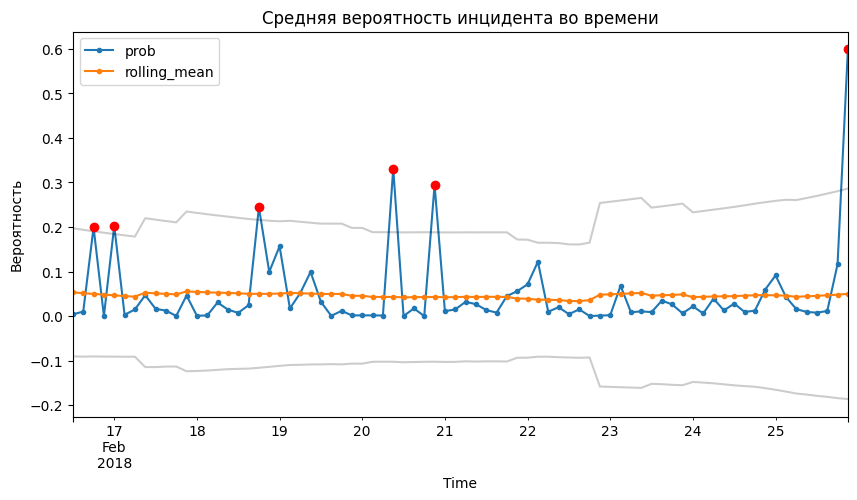

In [131]:
ts_test = test.groupby(by='start_date_round')['prob'].mean().to_frame()
anomaly_dates_probs_test = calculate_anomalies(ts_test, 
                    "prob", 
                    factor=2,
                    title="Средняя вероятность инцидента во времени",
                    ylabel="Вероятность");

In [137]:

anomaly_dates_probs_test

DatetimeIndex(['2018-02-16 18:00:00', '2018-02-17 00:00:00',
               '2018-02-18 18:00:00', '2018-02-20 09:00:00',
               '2018-02-20 21:00:00', '2018-02-25 21:00:00'],
              dtype='datetime64[ns]', name='start_date_round', freq=None)

In [192]:
# По нашей оценке, в данном случае, мы задетектили ложный инцидент. Поэтому итоговое количество инцидентов на тесте - 5
test[test["start_date_round"] == "2018-02-20 09:00:00"]

,id,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,...,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,prob,start_date_round
1940,16743,При выполнении Оператором НСИ пункта 8.3 Плана,Сервис240,3-Низкий,Закрыт,ФГ19,2018-02-23 08:36,2018-02-20 08:48:00,Инцидент,NaN,...,2018-02-20 10:12,2018-03-07 07:54:00,4-Нет,3-Малое,Система228,Место1,2018-02-20,2018-03-07,6.617320e-01,2018-02-20 09:00:00
1941,16744,Дистанционные курсы/тесты,Сервис36,3-Низкий,Отменен,ФГ47,2018-02-24 06:36,2018-02-20 09:48:00,Запрос,NaN,...,2018-02-20 11:54,NaT,4-Нет,4-Нет влияния,Система38,Место135,2018-02-20,NaT,3.391000e-08,2018-02-20 09:00:00
